<div align="justify">
  <h1> Modelagem e Controle de Robôs </h1>
  <h2><b> Atividade 2 </b></h2>
  <h3> Prof. Ícaro Bezerra Queiroz de Araújo</h3>
  <h3> Prof. Glauber Rodrigues Leite</h3>
  <h4><b>Alunos</b></h4>

  <b><i>Anderson Rafhael de Gusmão Barbosa - 18113000</i></b>

  <b><i>Derek Nielsen Araújo Alves - 17212092 </i></b>

  <b><i>Hugo Gabriel de Melo Santos - 18112109 </i></b>

  <b><i>John Davi Dutra Canuto Pires - 18112206</i></b>

  <b><i>Walmer Almeida Cavalcante - 17112916</i></b>

In [75]:
import numpy as np

from sympy import diff, Function, simplify, latex, linear_eq_to_matrix, Matrix
from sympy import sin as s, cos as c, symbols
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [17]:
init_vprinting()

In [115]:
t = symbols('t')
g = symbols('g')
L1, L2 = symbols('L_1'), symbols('L_2')
m2, m3 = symbols('m_2'), symbols('m_3')
theta1, theta2, theta3 = Function('\\theta_1')(t), Function('\\theta_2')(t), Function('\\theta_3')(t)

  Inicialmente iremos fazer a modelagem cinemática, para obter a jacobiana, em seguida, iremos realizar a criação da tabela DH dos centros de massa com o intuito de adquirir a velocidade dos centros de massa. Com essas informações, poderemos prosseguir para o cálculo da lagrangeana, onde a partir dela, finalmente poderemos encontrar os valores de torque para cada junta em função da aceleração. Após isso poderemos realizar a conversão para o espaço de tarefa.

# **Modelagem Cinemática**

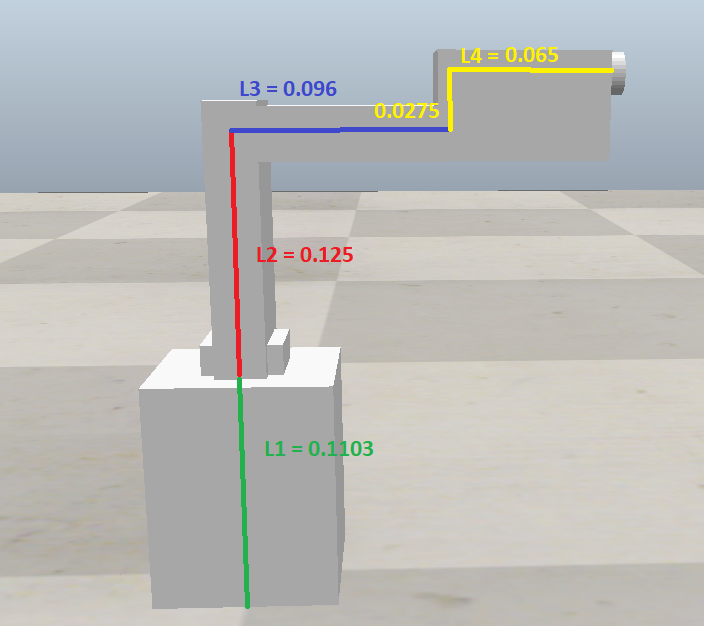

## Tabela de parâmetros DH

> | j   | theta   | d      | a      | alpha |
| --- | ------- | ------ | ------ | ----- |
| T01 | q1      | 0.1103 | 0      | -90   |
| T12 | q2 - 90 | 0      | 0.125  | 0     |
| T23 | q3 + 90 | 0      | 0.096  | 0     |
| T34 | 90      | 0      | -0.0275| 90    |
| T45 | 0       | 0.065  | 0      | 0     | 

## Funções

In [90]:
def dh_transform(theta, d, a, alpha, offset=0.):
        theta = theta + offset
        ct, st = c(theta), s(theta)
        if not(ct.atoms(theta)):
            ct = round(ct, 6)
            st = round(st, 6)
        ca, sa = round(c(alpha), 6), round(s(alpha), 6)
        return np.array([
            ct, -st*ca, st*sa, a*ct,
            st, ct*ca, -ct*sa, a*st,
            0., sa, ca, d,
            0., 0., 0., 1.
        ]).reshape(4, 4)

## Cinemática Direta

In [96]:
T01 = dh_transform(theta1, 0.1103, 0., -np.pi/2, 0) 

T12 = dh_transform(theta2, 0., 	0.125, 0., -np.pi/2) 

T23 = dh_transform(theta3, 0., 0.096, 0., np.pi/2) 

T34 = dh_transform(0, 0., -0.0275, np.pi/2, np.pi/2) 

T45 = dh_transform(0, 0.065, 0., 0., 0)

FKine = T01 @ T12 @ T23 @ T34 @ T45
#print(FKine)

fx = FKine[0, 3]
fy = FKine[1, 3]
fz = FKine[2, 3]

Matrix(simplify(FKine))

⎡-1.0⋅sin(\theta₂ + \theta₃)⋅cos(\theta₁)  -1.0⋅sin(\theta₁)  1.0⋅cos(\theta₂ 
⎢                                                                             
⎢-1.0⋅sin(\theta₂ + \theta₃)⋅sin(\theta₁)  1.0⋅cos(\theta₁)   1.0⋅sin(\theta₁)
⎢                                                                             
⎢      -1.0⋅cos(\theta₂ + \theta₃)                 0                -1.0⋅sin(\
⎢                                                                             
⎣                   0                              0                          

+ \theta₃)⋅cos(\theta₁)  (0.0275⋅sin(\theta₂ + \theta₃) + 0.125⋅sin(\theta₂) +
                                                                              
⋅cos(\theta₂ + \theta₃)  (0.0275⋅sin(\theta₂ + \theta₃) + 0.125⋅sin(\theta₂) +
                                                                              
theta₂ + \theta₃)          -0.161⋅sin(\theta₂ + \theta₃) - 7.65404249467096e-1
                                                   

## Jacobiana Analítica

In [97]:
X = Matrix([fx, fy, fz])
Y = Matrix([theta1, theta2, theta3])
analyticJacobian = X.jacobian(Y)

simplify(analyticJacobian)

⎡-(0.0275⋅sin(\theta₂ + \theta₃) + 0.125⋅sin(\theta₂) + 0.161⋅cos(\theta₂ + \t
⎢                                                                             
⎢(0.0275⋅sin(\theta₂ + \theta₃) + 0.125⋅sin(\theta₂) + 0.161⋅cos(\theta₂ + \th
⎢                                                                             
⎣                                                                  0          

heta₃) + 7.65404249467096e-18⋅cos(\theta₂))⋅sin(\theta₁)  (-0.161⋅sin(\theta₂ 
                                                                              
eta₃) + 7.65404249467096e-18⋅cos(\theta₂))⋅cos(\theta₁)   (-0.161⋅sin(\theta₂ 
                                                                              
                                                                 -0.0275⋅sin(\

+ \theta₃) - 7.65404249467096e-18⋅sin(\theta₂) + 0.0275⋅cos(\theta₂ + \theta₃)
                                                                              
+ \theta₃) - 7.65404249467096e-18⋅sin(\theta₂) + 0

# **Modelagem Dinâmica**

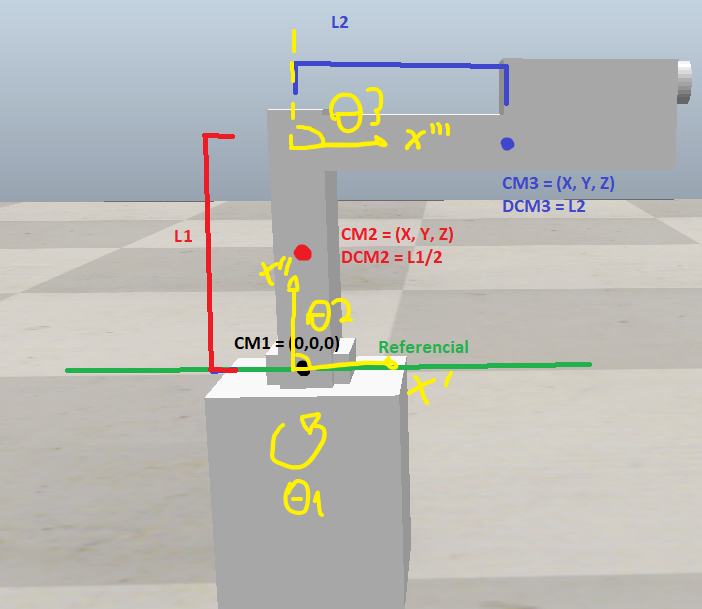

**Tabela DH dos centros de massa**

> | j   | theta   | d | a    | alpha    |
| --- | ------- | - | ---- | -------- |
| E01 | q1      | 0 | 0    | -$\pi$/2 |
| E12 | q2 - 90 | 0 | L1/2 | 0        |
| E12'| q2 - 90 | 0 | L1   | 0        |
| E23 | q3 + 90 | 0 | L2   | 0        |

In [102]:
E01 = dh_transform(theta1, 0, 0, -np.pi/2, 0) 

E12 = dh_transform(theta2, 0, L1/2, 0, -np.pi/2) 

E12l = dh_transform(theta1, 0, L1, 0, -np.pi/2) 

E23 = dh_transform(theta1, 0, L2, 0, np.pi/2) 

# Calculando as posições dos centros de massa

cm1X = 0
cm1Y = 0
cm1Z = 0

cm2 = E01 @ E12

cm2X = cm2[0, 3]
cm2Y = cm2[1, 3]
cm2Z = cm2[2, 3]

cm3 = E01 @ E12l @ E23

cm3X = cm3[0, 3]
cm3Y = cm3[1, 3]
cm3Z = cm3[2, 3]

# Calculando a velocidade de cada centro de massa

cm1XDiff = 0
cm1YDiff = 0
cm1ZDiff = 0

cm2XDiff = diff(cm2[0, 3], t)
cm2YDiff = diff(cm2[1, 3], t)
cm2ZDiff = diff(cm2[2, 3], t)

cm3XDiff = diff(cm3[0, 3], t)
cm3YDiff = diff(cm3[1, 3], t)
cm3ZDiff = diff(cm3[2, 3], t)

## Calculando a Lagrangeana

$\mathcal{L} = T - U$

In [109]:
# Cálculo da energia potencial

U = -m2 * g * L1/2 * s(theta2) - m3 * g * (L2 * s(theta2 + theta3) + L1 * s(theta2))
simplify(U)

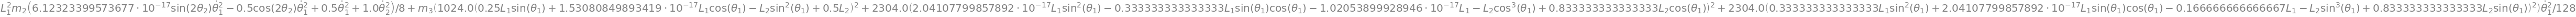

In [110]:
# Cálculo da energia cinética

T = (m2 * (cm2XDiff**2 + cm2YDiff**2 + cm2ZDiff**2)) / 2 + (m3 * (cm3XDiff**2 + cm3YDiff**2 + cm3ZDiff**2)) / 2
simplify(T)

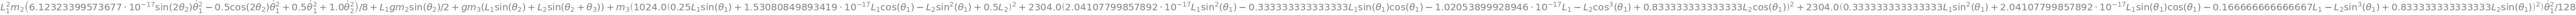

In [111]:
# Cálculo da lagrangeana

L = T - U
simplify(L)

## Cálculo dos valores de torque

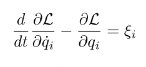

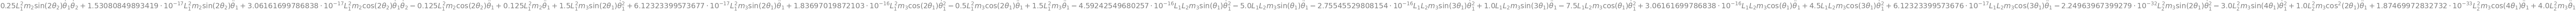

In [112]:
T1 = diff(diff(L, diff(theta1, t)), t) + diff(L, theta1)
simplify(T1)

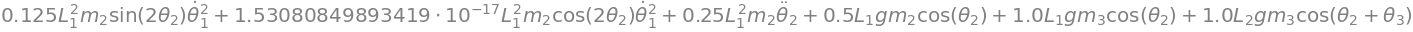

In [113]:
T2 = diff(diff(L, diff(theta2, t)), t) + diff(L, theta2)
simplify(T2)

In [114]:
T3 = diff(diff(L, diff(theta3, t)), t) + diff(L, theta3)
simplify(T3)

# **Conversão para o espaço de tarefa**

As seguintes equações dinâmicas podem espressar as coordenadas do frame do efetuador.
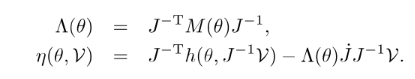

Onde:

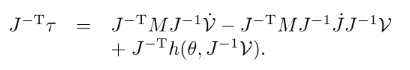

E

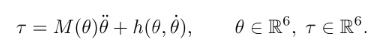

O qual a última equação correponde ao torque calculado logo acima.